# Vizuelizacija podataka o koncentraciji polena u vazduhu

Podaci korišćeni u projektu se pribavljaju preko otvorenog API-ja koji se nalazi na portalu otvorenih podataka kancelarije za informacione tehnologije i elektronsku upravu vlade Republike Srbije ( <a href="https://data.gov.rs/sr/datasets/kontsentratsije-polena-u-vazdukhu-api/">Koncentracija polena u vazduhu</a> ). API dokumentacija je realizovana preko swagger-a i nalazi se na lokaciji:   <a href="http://polen.sepa.gov.rs/api/opendata/schema">API dokumentacija</a>.


## Ideja o projektu

Ideja o realizaciji ovakvog projekta nastala je po ugledu na kartu na kojoj se prati trenutan nivo radioaktivnog zračenja koje se nalazi na <a href="https://www.srbatom.gov.rs/srbatomm/monitoring-radioaktivnosti/">Srbatom</a> sajtu. 

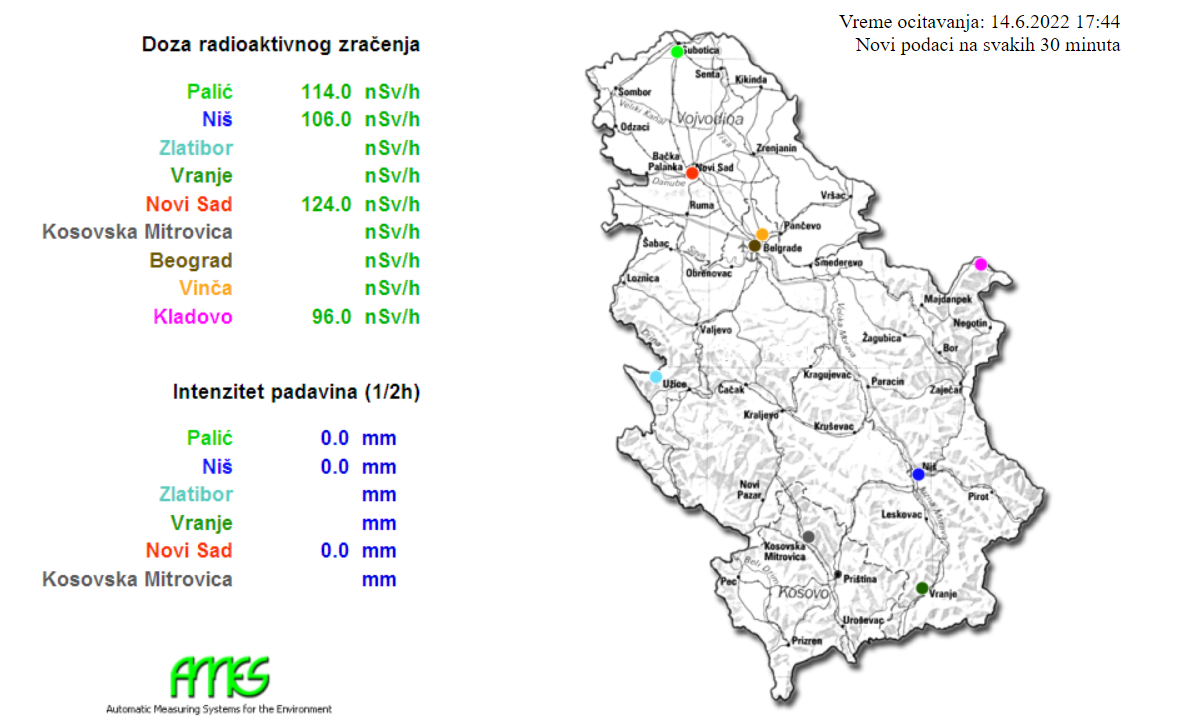

Na karti se mogu videti lokacije na kojima se meri trenutan nivo radioaktivnosti, a u legendi sa leve strane očitane vrednosti. Vrednosti se ažuriraju na svakih pola sata. Pošto nisam pronašao dostupan otvoren API za ovu kartu, krenuo sam u pretraživanje gore pomenutog sajta sa otvorenim API-jima i pronašao sličan samo za merenje koncentracije polena u vazduhu.


## O merenju koncentracije polena u vazduhu

Koncentracija alergenih polena u vazduhu se meri uredjajima tzv. "klopkama" za polen. Jedno merno mesto reprezentuje teritoriju od 30 do 50 km u precniku u zavisnosti od orografije terena. Koncentracije alergenog polena se izražavaju po metru kubnom vazduha za jedan dan. To su dakle dnevni podaci. Za jednu lokaciju i jedan alergen postoji jedan podatak za jedan dan. Tu ne figuriše vreme merenja već samo datum. Izgled "klopke" dat je na slici ispod.

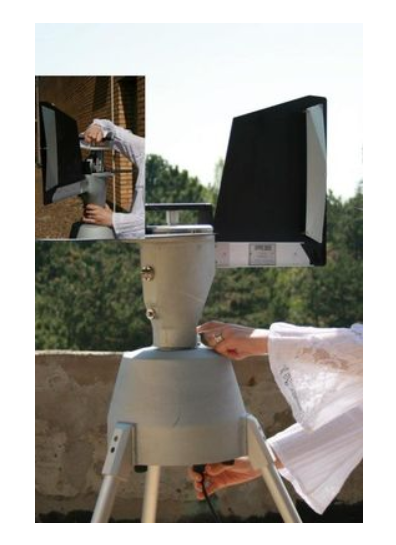


## Dostupni podaci

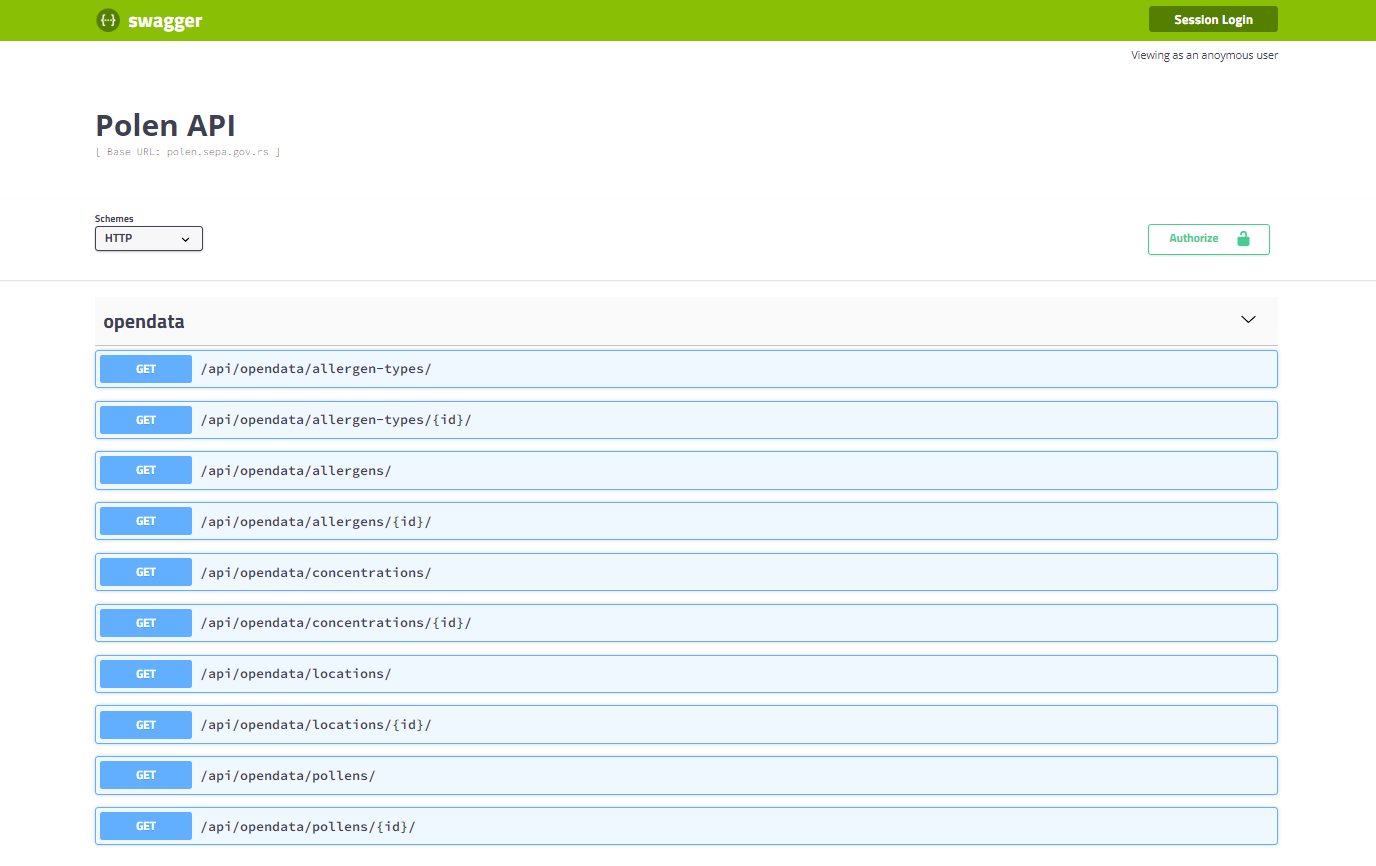

Na slici se može videti koji sve zahtevi ka bazi su dostupni. Dostupni su podaci o tipovima alergena, alergenima koji se mere, lokacijama na kojima su postavljeni uređaji i koncentraciji polena po lokacijama.

Na osnovu podataka datih u API-ju, šema baze podataka bi izgledalo kao na sledećem dijagramu:

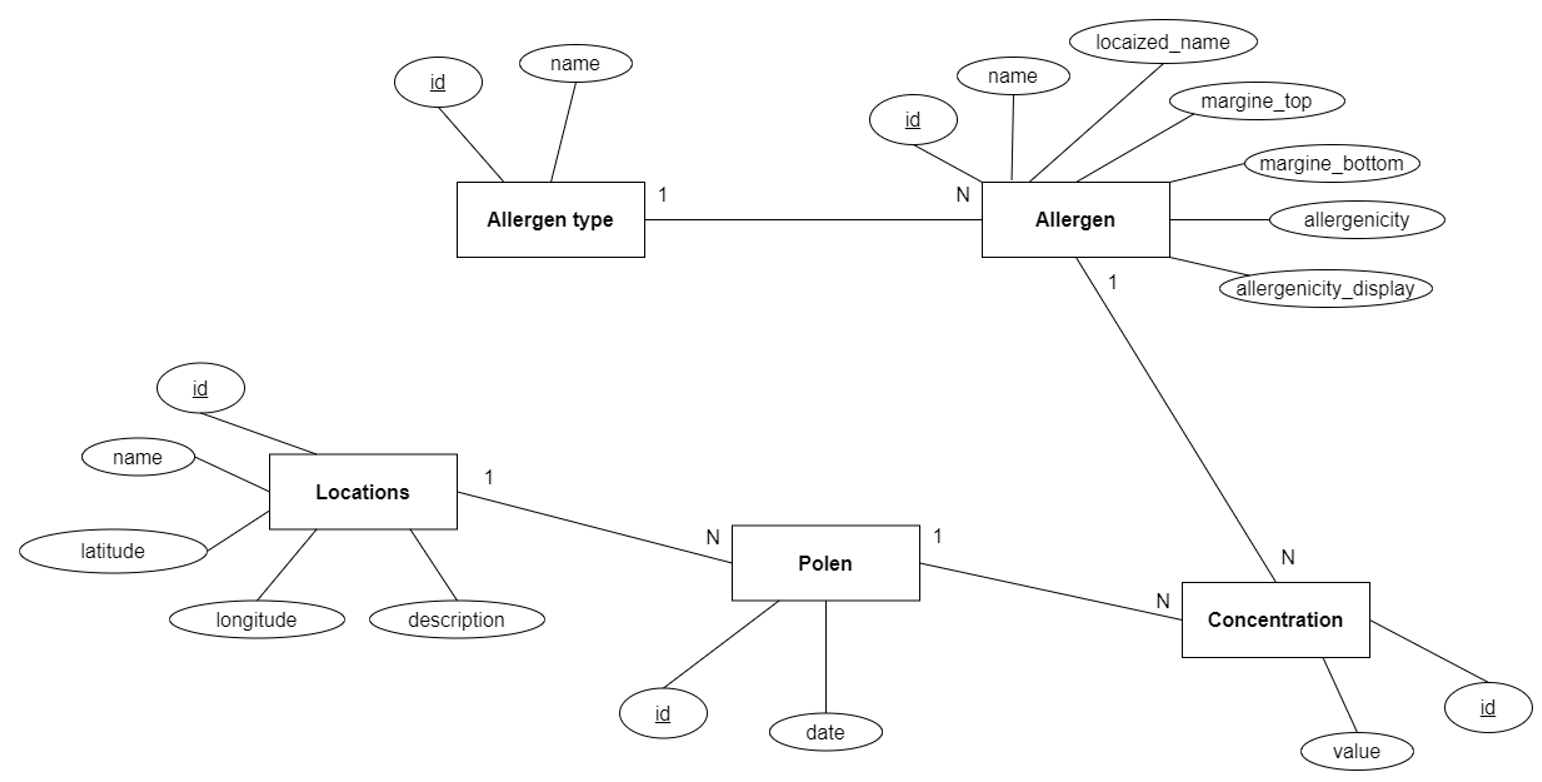


## Nedostaci i mane baze podataka

Na prvi pogled se mogu videti dve stvari:
1. Entiteti **Polen** i **Concentration** se mogu zameniti jednom vezom više na više između lokacije i alergena
2. Nedostaju podaci o graničnim vrednostima po alergenu, tj. koje su vrednosti normalne, ili neka vrsta kategorizacije vrednosti koncentracije

Na osnovu stavke 2 i činjenice da se detektovanje i prikupljanje vrednosti koncentracije polena realizuje na dnevnom nivou, nemoguće je napraviti tzv "live" kartu, već samo kartu za prikaz podataka iz prethodnih mernih perioda. Ako se ovome doda činjenica koju sam primetio, a to je da učitavanje podataka u bazu nije redovno, tj. podaci za današnji dan se ubacuju u toku narednih 3-5 dana, rešio sam da vršim prikaz podataka stari nedelju dana.

In [99]:
import folium
import pandas as pd
import numpy as np
import requests
import json
import streamlit as st
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ipywidgets
import geocoder
import geopy.distance
import branca.colormap as branca_folium_cm
from datetime import datetime, timedelta
from folium.plugins import HeatMap
from streamlit_folium import folium_static
from branca.element import Template, MacroElement

In [100]:
import warnings
warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [101]:
urls = {
    "locations": "http://polen.sepa.gov.rs/api/opendata/locations/",
    "allergens": "http://polen.sepa.gov.rs/api/opendata/allergens/",
    "pollens": "http://polen.sepa.gov.rs/api/opendata/pollens/"
    
}

In [102]:
locationsResult = requests.get(urls["locations"])
print(locationsResult)

<Response [200]>


In [103]:
# locationsResult.content() # Return the raw bytes of the data payload
# locationsResult.text() # Return a string representation of the data payload
locationsResult.json() # This method is convenient when the API returns JSON

[{'id': 2,
  'name': 'БЕОГРАД - ЗЕЛЕНО БРДО',
  'latitude': '44.786241',
  'longitude': '20.521657',
  'description': 'Zgrada Agencije'},
 {'id': 1,
  'name': 'БЕОГРАД - НОВИ БЕОГРАД',
  'latitude': '44.823174',
  'longitude': '20.412914',
  'description': 'Zgrada Opsine'},
 {'id': 17,
  'name': 'БЕЧЕЈ',
  'latitude': '45.613056',
  'longitude': '20.052766',
  'description': 'Zgrada sportskog centra Mladost'},
 {'id': 27,
  'name': 'ВАЉЕВО',
  'latitude': '44.270884',
  'longitude': '19.887231',
  'description': 'Zgrada Opstine'},
 {'id': 8,
  'name': 'ВРАЊЕ',
  'latitude': '42.551460',
  'longitude': '21.902314',
  'description': 'Zgrada Zavoda'},
 {'id': 25,
  'name': 'ВРБАС',
  'latitude': '45.572060',
  'longitude': '19.640300',
  'description': 'Zgrada Skupštine opštine'},
 {'id': 9,
  'name': 'ВРШАЦ',
  'latitude': '45.116670',
  'longitude': '21.303610',
  'description': ''},
 {'id': 10,
  'name': 'ЗАЈЕЧАР',
  'latitude': '43.906308',
  'longitude': '22.278354',
  'description':

In [104]:
serbia = folium.Map(
    zoom_start = 7,
    location = [44,21],
    tiles = "openstreetmap",
    max_zoom = 8,
    min_zoom = 7)
serbia

In [105]:
locations = locationsResult.json()

In [106]:
layerCoverage = folium.FeatureGroup(name="Teritory coverage", overlay=True, show=False)
layerCoverage.add_to(serbia)

In [107]:
for loc in locations:
    folium.features.Marker(
        location = [loc['latitude'], loc['longitude']],
        popup = loc['name'] + ' ' + loc['description'],
        tiles = 'openstreetmap',
        name = "openstreetmap"
    ).add_to(serbia)

In [108]:
allergensResult = requests.get(urls["allergens"])
allergensResult

<Response [200]>

In [109]:
allergensResult.json()[0]

{'id': 1,
 'name': 'ACER',
 'localized_name': 'ЈАВОР',
 'margine_top': 100,
 'margine_bottom': 60,
 'type': 1,
 'allergenicity': 1,
 'allergenicity_display': 'mild'}

In [110]:
allergens = allergensResult.json()

In [111]:
allergenList = [allergen['name'] + ' - ' + allergen['localized_name'] for allergen in allergens]
allergenList

['ACER - ЈАВОР',
 'ALNUS - ЈОВА',
 'AMBROSIA - АМБРОЗИЈА',
 'ARTEMISIA - ПЕЛИН',
 'BETULA - БРЕЗА',
 'CANNABACEAE - КОНОПЉЕ',
 'CARPINUS - ГРАБ',
 'CELTIS - КОПРИВИЋ',
 'CHENOP/AMAR. - ШТИРЕВИ/ПЕПЕЉУГЕ',
 'CORYLUS - ЛЕСКА',
 'CUPRESS/TAXA. - ТИСА/ЧЕМПР.',
 'FAGUS - БУКВА',
 'FRAXINUS - ЈАСЕН',
 'JUGLANS - ОРАХ',
 'MORACEAE - ДУД',
 'PINACEAE - ЧЕТИНАРИ',
 'PLANTAGO - БОКВИЦА',
 'PLATANUS - ПЛАТАН',
 'POACEAE - ТРАВЕ',
 'POPULUS - ТОПОЛА',
 'QUERCUS - ХРАСТ',
 'RUMEX - КИСЕЛИЦЕ',
 'SALIX - ВРБА',
 'TILIA - ЛИПА',
 'ULMACEAE - БРЕСТ',
 'URTICACEAE - КОПРИВА']

In [112]:
colors = cm.rainbow(np.linspace(0, 1, len(allergenList)))
colors

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.21568627e-01, 1.22888291e-01, 9.98103329e-01, 1.00000000e+00],
       [3.43137255e-01, 2.43913720e-01, 9.92420510e-01, 1.00000000e+00],
       [2.64705882e-01, 3.61241666e-01, 9.82973100e-01, 1.00000000e+00],
       [1.86274510e-01, 4.73093557e-01, 9.69796936e-01, 1.00000000e+00],
       [1.00000000e-01, 5.87785252e-01, 9.51056516e-01, 1.00000000e+00],
       [2.15686275e-02, 6.82748855e-01, 9.30229309e-01, 1.00000000e+00],
       [5.68627451e-02, 7.67362681e-01, 9.05873422e-01, 1.00000000e+00],
       [1.35294118e-01, 8.40344072e-01, 8.78081248e-01, 1.00000000e+00],
       [2.21568627e-01, 9.05873422e-01, 8.43667148e-01, 1.00000000e+00],
       [3.00000000e-01, 9.51056516e-01, 8.09016994e-01, 1.00000000e+00],
       [3.78431373e-01, 9.81822563e-01, 7.71297962e-01, 1.00000000e+00],
       [4.56862745e-01, 9.97705180e-01, 7.30653133e-01, 1.00000000e+00],
       [5.43137255e-01, 9.97705180e-01, 6.82748855e

In [113]:
j = 0
color_dict = { }
for c in colors:
    color_dict[allergenList[j]] = c
    j = j + 1

In [114]:
layer_dict = { }
for a in allergenList:
    layer = folium.FeatureGroup(name=a, overlay=True, show=False)
    layer.add_to(serbia)
    layer_dict[a] = layer

In [115]:
today = datetime.today()
yesterday = today - timedelta(days=1)
one_week_ago = today - timedelta(days=7)
date = one_week_ago.strftime('%Y-%m-%d')
date

'2022-06-07'

In [116]:
pollensResult = requests.get(urls["pollens"] + '?date=' + date) # a week ago
pollensResult

<Response [200]>

In [117]:
pollens = pollensResult.json()['results']
pollens[0]

{'id': 42987,
 'location': 9,
 'date': '2022-06-07',
 'concentrations': [519448,
  519449,
  519450,
  519451,
  519452,
  519453,
  519454,
  519455,
  519456,
  519457,
  519458,
  519459]}

In [118]:
def floatstohex(rgb):
    '''Takes an RGB tuple or list and returns a hex RGB string.'''
    return f'#{int(rgb[0]*255):02x}{int(rgb[1]*255):02x}{int(rgb[2]*255):02x}'

In [119]:
heat_map_data_dict = { }
circle_dict = { }
for i in allergenList:
    heat_map_data_dict[i] = []
    
for loc in locations:
    circle_dict[loc["id"]] = ""
    
i = 0
for pollen in pollens:
    loc = (list(filter(lambda x: x['id'] == pollen['location'], locations)))[0]
    for con in pollen['concentrations']:
        concentration = requests.get('http://polen.sepa.gov.rs/api/opendata/concentrations/'+str(con))
        concentration = concentration.json()
        allergen = (list(filter(lambda x: x['id']==concentration['allergen'], allergens)))[0]
        index = allergen['name'] + ' - ' + allergen['localized_name']
        newOne = [loc['latitude'], loc['longitude'], concentration['value']]
        heat_map_data_dict[index].append(newOne)
        circle_dict[loc["id"]] = circle_dict[loc["id"]] + "\n" + allergen['localized_name'] + ": " + str(concentration['value'])
        
        #folium.features.Circle(location = [loc['latitude'], loc['longitude']],
        #    radius = 30000,
        #    #color = floatstohex(color_dict[allergen['name'] + ' - ' + allergen['localized_name']]),
        #    color = None,
        #    fill = True,
        #    fill_color = floatstohex(color_dict[allergen['name'] + ' - ' + allergen['localized_name']])).add_to(layer_dict[allergen['name'] + ' - ' + allergen['localized_name']])
        
    i = i + 1

In [120]:
circle_dict

{2: '\nЧЕТИНАРИ: 3\nБОКВИЦА: 2\nТРАВЕ: 45\nКИСЕЛИЦЕ: 1\nЛИПА: 4\nКОПРИВА: 68',
 1: '',
 17: '\nКОНОПЉЕ: 3\nГРАБ: 1\nШТИРЕВИ/ПЕПЕЉУГЕ: 1\nТИСА/ЧЕМПР.: 7\nОРАХ: 1\nЧЕТИНАРИ: 5\nТРАВЕ: 71\nХРАСТ: 2\nКИСЕЛИЦЕ: 2\nЛИПА: 1\nКОПРИВА: 23',
 27: '\nЧЕТИНАРИ: 2\nБОКВИЦА: 5\nТРАВЕ: 34\nЛИПА: 55\nКОПРИВА: 30',
 8: '',
 25: '\nТИСА/ЧЕМПР.: 1\nЧЕТИНАРИ: 1\nПЛАТАН: 1\nТРАВЕ: 21\nКИСЕЛИЦЕ: 1\nЛИПА: 7\nКОПРИВА: 69',
 9: '\nАМБРОЗИЈА: 1\nКОНОПЉЕ: 5\nТИСА/ЧЕМПР.: 2\nБУКВА: 1\nОРАХ: 1\nЧЕТИНАРИ: 2\nБОКВИЦА: 1\nТРАВЕ: 29\nТОПОЛА: 0\nКИСЕЛИЦЕ: 1\nЛИПА: 5\nКОПРИВА: 24',
 10: '',
 16: '\nЧЕТИНАРИ: 12\nТРАВЕ: 109\nКИСЕЛИЦЕ: 26\nКОПРИВА: 37',
 26: '',
 22: '',
 4: '',
 12: '\nЈАВОР: 0\nБРЕЗА: 0\nГРАБ: 0\nТИСА/ЧЕМПР.: 0\nБУКВА: 0\nЈАСЕН: 0\nОРАХ: 0\nДУД: 0\nПЛАТАН: 0\nТРАВЕ: 0\nХРАСТ: 0\nКОПРИВА: 0',
 5: '\nЧЕТИНАРИ: 1\nТРАВЕ: 14\nКОПРИВА: 16',
 6: '',
 14: '',
 15: '\nТИСА/ЧЕМПР.: 2\nТРАВЕ: 28\nВРБА: 3\nЛИПА: 26\nКОПРИВА: 13',
 20: '\nЧЕТИНАРИ: 1\nБОКВИЦА: 2\nТРАВЕ: 1\nХРАСТ: 2\nКИСЕЛИЦЕ: 2\nКОПРИВА: 8',
 21: '

In [121]:
heat_map_data_dict

{'ACER - ЈАВОР': [['43.892702', '20.344355', 1],
  ['43.723994', '20.688908', 0]],
 'ALNUS - ЈОВА': [['46.104969', '19.668574', 0]],
 'AMBROSIA - АМБРОЗИЈА': [['45.116670', '21.303610', 1]],
 'ARTEMISIA - ПЕЛИН': [],
 'BETULA - БРЕЗА': [['43.892702', '20.344355', 4],
  ['43.723994', '20.688908', 0]],
 'CANNABACEAE - КОНОПЉЕ': [['45.116670', '21.303610', 5],
  ['45.613056', '20.052766', 3],
  ['44.870078', '20.640069', 1],
  ['46.104969', '19.668574', 2]],
 'CARPINUS - ГРАБ': [['45.613056', '20.052766', 1],
  ['43.723994', '20.688908', 0]],
 'CELTIS - КОПРИВИЋ': [],
 'CHENOP/AMAR. - ШТИРЕВИ/ПЕПЕЉУГЕ': [['45.613056', '20.052766', 1],
  ['46.104969', '19.668574', 1],
  ['44.621157', '21.189076', 1]],
 'CORYLUS - ЛЕСКА': [],
 'CUPRESS/TAXA. - ТИСА/ЧЕМПР.': [['45.116670', '21.303610', 2],
  ['45.613056', '20.052766', 7],
  ['44.971610', '19.612680', 1],
  ['43.316286', '21.913684', 2],
  ['43.892702', '20.344355', 3],
  ['46.104969', '19.668574', 1],
  ['45.572060', '19.640300', 1],
  ['43.

In [122]:
def maxColumn(L, col):    
    if(len(L) == 0 or len(L) <= col):
        return 1
    return list(map(max, zip(*L)))[col]
def calculateGradient(max):
    return {
        0.1: 'rgba(0.0,0.3,0.9,0.4)', 
        3: 'rgba(0.0,0.9,0.3,0.4)', 
        5: 'rgba(0.9,1.0,0.1,0.4)', 
        7: 'rgba(1.0,0.6,0.0,0.4)', 
        30: 'rgba(1.0,0.0,0.1,0.4)'
    }

```
z_min = 1.4117859851611496e-05
z_max = 0.009847076523171685

colormap = branca_folium_cm.linear.Blues_05.scale(z_min, z_max)
colormap.caption = "Bla bla"
gradient_dict = {}
serbia.add_child(colormap);

num=0
nmm=.1
for ind_val, c in zip(colormap.index, colormap.colors):
    r, g, b, a = c
    gradient_dict[num] = calculateGradient(0)[nmm]#f"rgba({r},{g},{b},{a})"
    num = num + 1
    nmm = nmm + 0.2
gradient_dict
```

In [123]:
legend_color_dict ={
        0: '#004de666', 
        1: '#00e64d66', 
        2: '#e6ff1966', 
        3: '#ff990066', 
        4: '#ff001966'
}

legend_color_dict ={
        0: '#004de666', 
        1: '#00e64d66', 
        2: '#e6ff1966', 
        3: '#ff990066', 
        4: '#ff001966'
}
def calculateValueGradient(max):
    return {
        0: 0.1 * max, 
        1: 0.3 * max,
        2: 0.5 * max,
        3: 0.7 * max,
        4: 0.9 * max
    }
def generateLayerTemplate(listValue):

    
    top = """
    {% macro html(this, kwargs) %}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>jQuery UI Draggable - Default functionality</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

      <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
      <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

      <script>
      $( function() {
        $( "#maplegend" ).draggable({
                        start: function (event, ui) {
                            $(this).css({
                                right: "auto",
                                top: "auto",
                                bottom: "auto"
                            });
                        }
                    });
    });

      </script>
    </head>
    <body>
    """
    
    
    bot = """
    </body>
    </html>

    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>

    {% endmacro %}"""
    
    
    
    template_part = f"""
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
         border-radius:6px; padding: 10px; font-size:14px; right: 20px; top: 20px;'>

    <div class='legend-title'>Legenda<br></div>
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:{legend_color_dict[0]};opacity:0.7;'></span> {listValue[0]} </li>
        <li><span style='background:{legend_color_dict[1]};opacity:0.7;'></span> {listValue[1]} </li>
        <li><span style='background:{legend_color_dict[2]};opacity:0.7;'></span> {listValue[2]} </li>
        <li><span style='background:{legend_color_dict[3]};opacity:0.7;'></span> {listValue[3]} </li>
        <li><span style='background:{legend_color_dict[4]};opacity:0.7;'></span> {listValue[4]} </li>
        <li><span style='background:repeating-linear-gradient(
        -55deg,
        #ffffff,
        #ffffff 5px,
        #b2b2b2 5px,
        #b2b2b2 10px);
        opacity:0.7;'></span>No sales</li>
      </ul>
    </div>
    </div>
    """
    
    
    template = f"""
    {top}
    {template_part}
    {bot}
    """
    
    return template

In [124]:
for loc in locations:
    folium.features.Circle(location = [loc['latitude'], loc['longitude']],
        radius = 25000,
        color = None,
        fill = True,
        fill_color = "",
        popup = circle_dict[loc["id"]]
    ).add_to(layerCoverage)

In [125]:
for i in allergenList:
    grad = calculateValueGradient(maxColumn(heat_map_data_dict[i], 2))
    HeatMap(heat_map_data_dict[i],radius=30,min_opacity=0.05).add_to(layer_dict[i])
macro = MacroElement()
macro._template = Template(generateLayerTemplate(['veoma niska', 'niska', 'srednja', 'visoka', 'veoma visoka']))
serbia.get_root().add_child(macro)

In [126]:
folium.LayerControl().add_to(serbia)

In [127]:
# widget function
def get_distance(start_address, stop_lat, stop_lon, stop_address):
    
    # string addresses to location information
    start_location = geocoder.osm(start_address)
    #stop_location = geocoder.osm(stop_address)
    
    # pull out latitude and longitude from location information
    start_latlng = [start_location.lat, start_location.lng]
    stop_latlng = [stop_lat, stop_lon]
    
    # calculate distance from start point to stop point using latitudes and longitudes
    distance = geopy.distance.distance(start_latlng, stop_latlng).meters
    print(f'distance between {start_address} and {stop_address}: {distance:.2f} meters')
    
    return f'{distance:.2f}'

In [128]:
serbia.add_child(folium.LatLngPopup())

# measure control
measure_control = folium.plugins.MeasureControl(position='topleft', 
                                         active_color='red', 
                                         completed_color='red', 
                                         primary_length_unit='miles')

# add measure control to map
serbia.add_child(measure_control)

# text widget
address_text_box = ipywidgets.Text(value='', placeholder='type here', description='address:')

# widget function
def plot_locations(address):
    # location address
    location = geocoder.osm(address)
    
    # latitude and longitude of location
    latlng = [location.lat, location.lng]
    
    min_distance = get_distance(address, locations[0]['latitude'], locations[0]['longitude'], locations[0]['name'])
    min_city = locations[0]['name']
    min_address = ""
    min_value = 0
    min_lat = locations[0]['latitude']
    min_lon = locations[0]['longitude']
    for loc in locations:        
        tmp_distance = get_distance(address,loc['latitude'],loc['longitude'], loc['name'])
        #print(min_distance)
        #print(tmp_distance)
        if(float(tmp_distance) < float(min_distance)):
            min_distance = tmp_distance
            min_city = loc['name'] + loc['description']
            min_address = loc['name']
            min_lat = loc['latitude']
            min_lon = loc['longitude']
    
    pop_msg = "/"
    if(float(min_distance) <= 50000):
        pop_msg = "pogledajte mernu stanicu: " + min_city
    
    map_distance = folium.Map(zoom_start=7,
    location=[43.5,21])
    # marker
    folium.Marker(latlng, popup=str(pop_msg), tooltip='click').add_to(map_distance)
    
    # display map
    #display(serbia)
    
    # map
    start_location = geocoder.osm(address)
    stop_location = geocoder.osm(min_address)
    
    print(start_location)
    print(stop_location)
    
    # pull out latitude and longitude from location information
    start_latlng = [start_location.lat, start_location.lng]
    stop_latlng = [float(min_lat), float(min_lon)]
    
    distance_path = [(start_latlng), (stop_latlng)]
    
    folium.plugins.AntPath(distance_path).add_to(map_distance)
    display(map_distance)

In [129]:
# interaction between widget and function    
ipywidgets.interact_manual(plot_locations, address=address_text_box)
serbia

interactive(children=(Text(value='', description='address:', placeholder='type here'), Button(description='Run…